In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
import pypsa
import pandas as pd
from dataclasses import dataclass

In [114]:
full_demand = pd.read_csv("../data/demand.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
full_wind_on_shore = pd.read_csv("../data/on_shore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_wind_off_shore = pd.read_csv("../data/off_shore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))

In [115]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24

In [116]:
demand = full_demand.get_group(climatic_year)
wind_on_shore = full_wind_on_shore.get_group(climatic_year)
wind_off_shore = full_wind_off_shore.get_group(climatic_year)

In [117]:
network = pypsa.Network(snapshots=demand.index[0:time_horizon_in_hours])

In [119]:
network.add("Bus", name="Poland", x=19.397666, y=52.455567)

In [ ]:
@dataclass
class Carriers:
    Battery = 0
    Biomass = 0
    Coal = 760
    Gas = 370
    Oil = 406
    Hydrogen = 0
    Hydro = 0
    Nuclear = 0
    Pumped = 0
    Reservoir = 0
    Solar = 0
    Wind = 0

In [121]:
for name, co2_emission in Carriers().__dict__.items():
    network.add("Carrier", name=name, co2_emissions=co2_emission)

In [122]:
coal_marginal_costs = 128 / 7 / 0.37 
gas_marginal_costs = 2.65 * 26.4 * 0.75 / 14.9 / 0.5
oil_marginal_costs = 73 * 0.119 / 12.5 / 0.40

In [123]:
generators = [
    {"name": "Stinky-Coal", "carrier": "Coal", "p_nom": 30742, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": coal_marginal_costs, "efficiency": 0.37, "committable": True, "min_up_time": 1, "min_down_time": 2},
    {"name": "Stinky-Gas", "carrier": "Gas", "p_nom": 255.5, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.5,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Stinky-Oil", "carrier": "Oil", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": oil_marginal_costs, "efficiency": 0.4,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Biomass", "carrier": "BioEnergies", "p_nom":0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": 0, "efficiency": 0.5, 
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 395, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost":0, "efficiency": 1, "committable": True,
     "min_up_time": 2, "min_down_time": 2},
    {"name": "Wind", "carrier": "Wind", "p_nom": 1760, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": 0, "efficiency":1, "committable": False},
    ]

In [124]:
for generator in generators:
    network.add("Generator", bus="Poland", **generator,)

In [125]:
loads = [
    {"name": "Poland-load", "bus": "Poland", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values},
]   

In [126]:
for load in loads:
    network.add("Load", **load)

In [127]:
network

PyPSA Network
Components:
 - Bus: 1
 - Carrier: 12
 - Generator: 6
 - Load: 1
Snapshots: 8760

In [128]:
result = network.optimize(solver_name="gurobi")
print(result)   

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Gurobi 11.0.0 (beta1) - expires 2023-11-21


INFO:gurobipy:Gurobi 11.0.0 (beta1) - expires 2023-11-21


Academic license - for non-commercial use only - expires 2024-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2024-11-20
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 39.94it/s]
INFO:linopy.io: Writing time: 1.73s


Read LP format model from file /tmp/linopy-problem-dpx8u3rt.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-dpx8u3rt.lp


Reading time = 0.60 seconds


INFO:gurobipy:Reading time = 0.60 seconds


obj: 289071 rows, 183960 columns, 648208 nonzeros


INFO:gurobipy:obj: 289071 rows, 183960 columns, 648208 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0beta2 (linux64 - "Ubuntu 22.04.3 LTS")


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0beta2 (linux64 - "Ubuntu 22.04.3 LTS")


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-7300HQ CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-7300HQ CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 4 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 289071 rows, 183960 columns and 648208 nonzeros


INFO:gurobipy:Optimize a model with 289071 rows, 183960 columns and 648208 nonzeros


Model fingerprint: 0x7a1ee057


INFO:gurobipy:Model fingerprint: 0x7a1ee057


Variable types: 52560 continuous, 131400 integer (131400 binary)


INFO:gurobipy:Variable types: 52560 continuous, 131400 integer (131400 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 3e+04]


INFO:gurobipy:  Matrix range     [1e+00, 3e+04]


  Objective range  [2e+00, 5e+01]


INFO:gurobipy:  Objective range  [2e+00, 5e+01]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 3e+04]


INFO:gurobipy:  RHS range        [1e+00, 3e+04]


Presolve removed 254040 rows and 157685 columns


INFO:gurobipy:Presolve removed 254040 rows and 157685 columns


Presolve time: 0.38s


INFO:gurobipy:Presolve time: 0.38s


Presolved: 35031 rows, 26275 columns, 105092 nonzeros


INFO:gurobipy:Presolved: 35031 rows, 26275 columns, 105092 nonzeros


Variable types: 0 continuous, 26275 integer (26275 binary)


INFO:gurobipy:Variable types: 0 continuous, 26275 integer (26275 binary)


Found heuristic solution: objective 7.227901e+09


INFO:gurobipy:Found heuristic solution: objective 7.227901e+09


INFO:gurobipy:


Explored 1 nodes (0 simplex iterations) in 1.01 seconds (0.91 work units)


INFO:gurobipy:Explored 1 nodes (0 simplex iterations) in 1.01 seconds (0.91 work units)


Thread count was 4 (of 4 available processors)


INFO:gurobipy:Thread count was 4 (of 4 available processors)


INFO:gurobipy:


Solution count 1: 7.2279e+09 


INFO:gurobipy:Solution count 1: 7.2279e+09 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 7.227901456197e+09, best bound 7.227901456197e+09, gap 0.0000%


INFO:gurobipy:Best objective 7.227901456197e+09, best bound 7.227901456197e+09, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 183960 primals, 0 duals
Objective: 7.23e+09
Solver model: available
Solver message: 2



('ok', 'optimal')


<Axes: xlabel='Generator', ylabel='GW'>

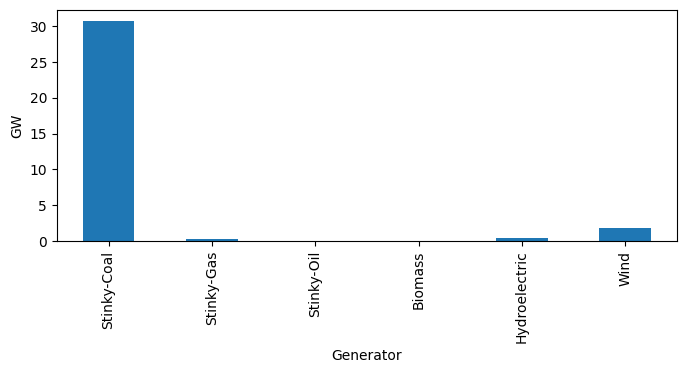

In [129]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

<Axes: xlabel='snapshot', ylabel='GW'>

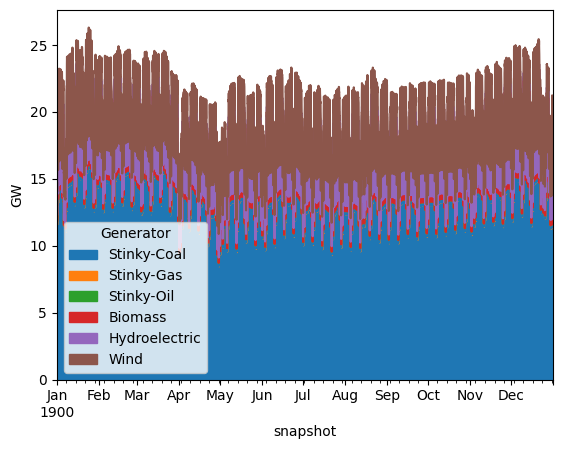

In [130]:
network.generators_t.p.div(1e3).plot.area(subplots=False, ylabel="GW")

In [131]:
network.generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [1900-01-01 00:00:00, 1900-01-01 01:00:00, 1900-01-01 02:00:00, 1900-01-01 03:00:00, 1900-01-01 04:00:00, 1900-01-01 05:00:00, 1900-01-01 06:00:00, 1900-01-01 07:00:00, 1900-01-01 08:00:00, 1900-01-01 09:00:00, 1900-01-01 10:00:00, 1900-01-01 11:00:00, 1900-01-01 12:00:00, 1900-01-01 13:00:00, 1900-01-01 14:00:00, 1900-01-01 15:00:00, 1900-01-01 16:00:00, 1900-01-01 17:00:00, 1900-01-01 18:00:00, 1900-01-01 19:00:00, 1900-01-01 20:00:00, 1900-01-01 21:00:00, 1900-01-01 22:00:00, 1900-01-01 23:00:00, 1900-01-02 00:00:00, 1900-01-02 01:00:00, 1900-01-02 02:00:00, 1900-01-02 03:00:00, 1900-01-02 04:00:00, 1900-01-02 05:00:00, 1900-01-02 06:00:00, 1900-01-02 07:00:00, 1900-01-02 08:00:00, 1900-01-02 09:00:00, 1900-01-02 10:00:00, 1900-01-02 11:00:00, 1900-01-02 12:00:00, 1900-01-02 13:00:00, 1900-01-02 14:00:00, 1900-01-02 15:00:00, 1900-01-02 16:00:00, 1900-01-02 17:00:00, 1900-01-02 18:00:00, 1900-01-02 19:00:00, 1900-01-02 20:00:00, 1900